In [72]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import scipy
from scipy.stats import pearsonr
import sklearn
from sklearn import datasets, linear_model
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn import tree
from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score
from sklearn import svm
from sklearn import linear_model


import pickle
from datetime import datetime


## Helper Functions

In [3]:
def save_model(model, save_path='auto_mpg/models/', name=""):
    time_stamp = datetime.now().strftime("%d-%b-%Y-%H-%M-%S")
    save_file_name = f'{save_path}{time_stamp}-{name}.pickle'
    with open(save_file_name, 'wb') as f:
        pickle.dump(model, f)
        print(f'Saved in {save_file_name}')
        
def get_outlier_info(series):
    
    quant_25 = np.quantile(series, 0.25)
    quant_75 = np.quantile(series, 0.75)

    lower_outlier_gate = quant_25 - ((1.5) * (quant_75 - quant_25))
    upper_outlier_gate = quant_75 + ((1.5) * (quant_75 - quant_25))

    
    return lower_outlier_gate, upper_outlier_gate


def get_outlier_val_counts(series, lower_outlier_gate, upper_outlier_gate):
    
    lower_outliers = series[series < lower_outlier_gate]
    upper_outliers = series[series > upper_outlier_gate]

    return {lower_outlier_gate : [len(lower_outliers), lower_outliers], upper_outlier_gate : [len(upper_outliers), upper_outliers]}

def clean_outliers(df, col_name, lower_cutoff_thresh, upper_cutoff_thresh):
    
    df.loc[df[col_name] > upper_cutoff_thresh, col_name] = upper_cutoff_thresh
    df.loc[df[col_name] < lower_cutoff_thresh, col_name] = lower_cutoff_thresh
    
    return df

def train_val_test_split(Xy, train_ratio=0.7, only_test=False):
    
    np.random.shuffle(Xy)
    total_count = Xy.shape[0]
    train_count = int(train_ratio * total_count)
    val_count = int((total_count - train_count)/2)
    test_count = total_count - (train_count + val_count)
    
    return Xy[:train_count], Xy[train_count:train_count+val_count], Xy[train_count+val_count:]
    

# Loading and clearning the data

In [50]:
columns = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', \
         'acceleration', 'model_year', 'origin', 'car_name']

auto_mpg_df = pd.read_csv('auto_mpg/auto-mpg.data', delim_whitespace=True, names=columns)
auto_mpg_df.drop(columns=['car_name'], inplace=True)
# auto_mpg_df.drop(columns=['car_name', 'weight'], inplace=True)

#Converting the column from object to float, coercing the error due to the presence of '?' in the column
auto_mpg_df['horsepower'] = pd.to_numeric(auto_mpg_df['horsepower'], errors='coerce')

# Using forward fill to replace NaN values
auto_mpg_df['horsepower'] = auto_mpg_df["horsepower"].fillna(method='ffill')

In [24]:
auto_mpg_df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model_year      0
origin          0
dtype: int64

## Basic EDA

In [21]:
auto_mpg_df.describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.513693,5.454774,193.425879,103.706030,2970.424623,15.552010,76.010050,1.572864
std,7.813400,1.701004,104.269838,36.951415,846.841774,2.693089,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.800000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,92.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,125.000000,3608.000000,17.175000,79.000000,2.000000
max,46.250000,8.000000,455.000000,200.000000,5140.000000,22.200000,82.000000,3.000000


# Quantile plot analysis 

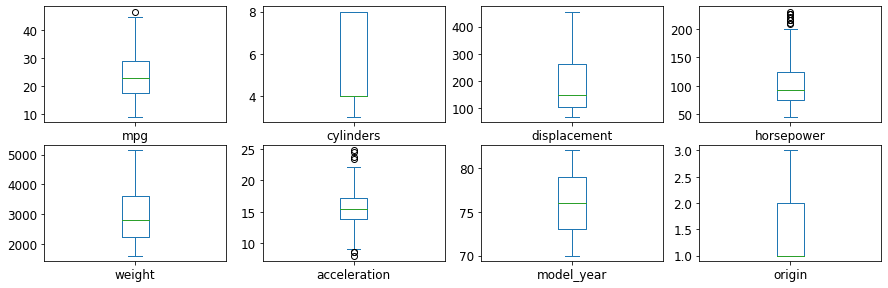

In [25]:
auto_mpg_df.plot(kind='box', subplots=True, layout=(8,4), sharex=False, sharey=False, fontsize=12, figsize=(15,20))
plt.show()

# Comparing Feature columns with target columns

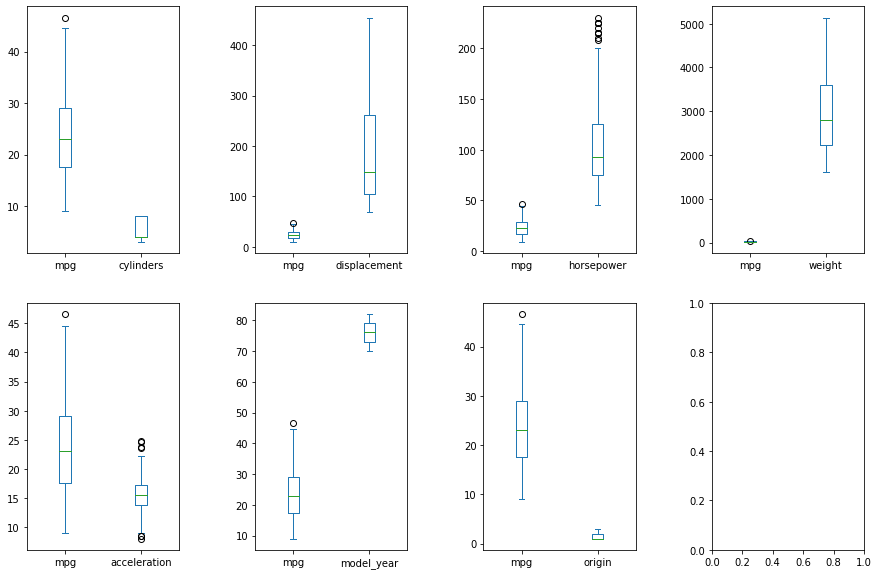

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,10))
fig.subplots_adjust(hspace =.2, wspace=.5)

axes = axes.ravel()
for i, col in enumerate(auto_mpg_df.columns[1:]):
    auto_mpg_df[['mpg', col]].plot(kind='box', ax=axes[i])

# Replacing the outliers
### Replacing the outlier values with the upper gate  and the lower gate of the quantile plot

In [90]:
# Cleaning the outliers by replacing the outlier values with the Upper gate of the quantile plot
val_dict_list = []

for col in auto_mpg_df.columns:
    
    lower_outlier_gate, upper_outlier_gate = get_outlier_info(auto_mpg_df[col])
    auto_mpg_df = clean_outliers(auto_mpg_df, col, lower_outlier_gate, upper_outlier_gate)
    
    #Sanity Check
    val_dict = get_outlier_val_counts(auto_mpg_df[col], lower_outlier_gate, upper_outlier_gate)
    val_dict_list.append(val_dict)
    
    

            
print(val_dict_list)

[{0.25: [0, Series([], Name: mpg, dtype: float64)], 46.25: [0, Series([], Name: mpg, dtype: float64)]}, {-2.0: [0, Series([], Name: cylinders, dtype: int64)], 14.0: [0, Series([], Name: cylinders, dtype: int64)]}, {-132.375: [0, Series([], Name: displacement, dtype: float64)], 498.625: [0, Series([], Name: displacement, dtype: float64)]}, {0.0: [0, Series([], Name: horsepower, dtype: float64)], 200.0: [0, Series([], Name: horsepower, dtype: float64)]}, {147.375: [0, Series([], Name: weight, dtype: float64)], 5684.375: [0, Series([], Name: weight, dtype: float64)]}, {8.8: [0, Series([], Name: acceleration, dtype: float64)], 22.2: [0, Series([], Name: acceleration, dtype: float64)]}, {64.0: [0, Series([], Name: model_year, dtype: int64)], 88.0: [0, Series([], Name: model_year, dtype: int64)]}, {-0.5: [0, Series([], Name: origin, dtype: float64)], 3.5: [0, Series([], Name: origin, dtype: float64)]}]


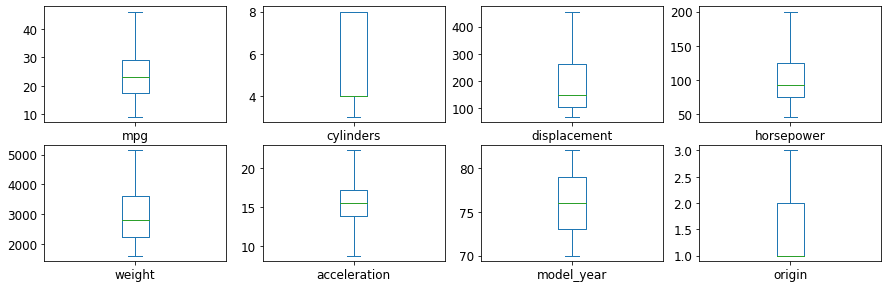

In [91]:
auto_mpg_df.plot(kind='box', subplots=True, layout=(8,4), sharex=False, sharey=False, fontsize=12, figsize=(15,20))
plt.show()

## Correlation Analysis

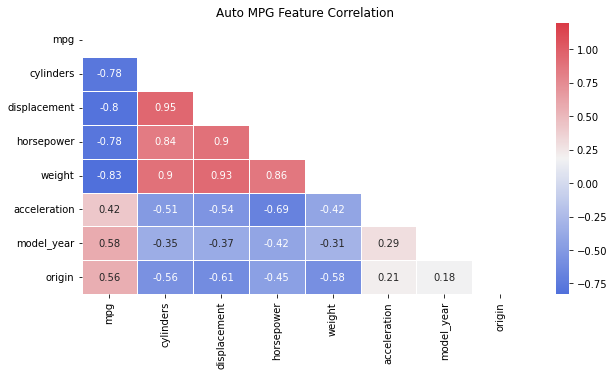

In [73]:
corrMatt = auto_mpg_df.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10,5))
plt.title('Auto MPG Feature Correlation')
# Generate a custom diverging colormap
cmap = sns.diverging_palette(260, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatt, vmax=1.2, square=False, cmap=cmap, mask=mask,
ax=ax, annot=True, fmt='.2g', linewidths=1);

# Model Training

In [74]:
auto_mpg_df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [51]:
train, test = train_test_split(auto_mpg_df.to_numpy(), test_size=0.25)
train.shape, test.shape
# train.reset_index(drop=True, inplace=True)

((298, 8), (100, 8))

## Normalizing the data

In [52]:
scalerTrainX = StandardScaler()
scalerTrainY = StandardScaler()

trainX = scalerTrainX.fit_transform(train[:, 1:])
trainY = scalerTrainY.fit_transform(train[:, 0].reshape(-1, 1))

testX = scalerTrainX.transform(test[:, 1:])
testY = scalerTrainY.transform(test[:, 0].reshape(-1, 1))

## Sanity check if the normalization worked as we intended it to

In [28]:
index=5

print(f'Train Mean : {np.average(trainX[:,index]):.20f}', f'Train std : {np.std(trainX[:,index]):.20f}')
print(f'Test Mean : {np.average(testX[:,index]):.20f}', f'Test std: {np.std(testX[:,index]):.20f}')

print(f'TrainY Mean : {np.average(trainY[:,0]):.20f}', f'TrainY std : {np.std(trainY[:,0]):.20f}')
print(f'TestY Mean : {np.average(testY[:,0]):.20f}', f'TestY std : {np.std(testY[:,0]):.20f}')

Train Mean : 0.00000000000000106701 Train std : 1.00000000000000022204
Test Mean : -0.09068552582979869103 Test std: 1.00810622691880058532
TrainY Mean : -0.00000000000000010730 TrainY std : 1.00000000000000022204
TestY Mean : -0.01771796578208210959 TestY std : 0.87567742514244251151


# Training a MLP model

In [11]:
regrMLP  = MLPRegressor(random_state=1, solver='sgd', early_stopping=True, max_iter=200, learning_rate='adaptive', verbose=True, hidden_layer_sizes=10, batch_size=8)

In [12]:
regrMLP.fit(trainX, trainY.ravel())

Iteration 1, loss = 0.40103416
Validation score: 0.174688
Iteration 2, loss = 0.21768573
Validation score: 0.413739
Iteration 3, loss = 0.15396304
Validation score: 0.552426
Iteration 4, loss = 0.12596935
Validation score: 0.643209
Iteration 5, loss = 0.10865928
Validation score: 0.706226
Iteration 6, loss = 0.09724525
Validation score: 0.748240
Iteration 7, loss = 0.08936818
Validation score: 0.780440
Iteration 8, loss = 0.08395304
Validation score: 0.801002
Iteration 9, loss = 0.08012992
Validation score: 0.816472
Iteration 10, loss = 0.07681724
Validation score: 0.829460
Iteration 11, loss = 0.07449064
Validation score: 0.835958
Iteration 12, loss = 0.07229966
Validation score: 0.848216
Iteration 13, loss = 0.07141670
Validation score: 0.850902
Iteration 14, loss = 0.06946293
Validation score: 0.858508
Iteration 15, loss = 0.06847563
Validation score: 0.860606
Iteration 16, loss = 0.06750321
Validation score: 0.862942
Iteration 17, loss = 0.06667284
Validation score: 0.863581
Iterat

MLPRegressor(batch_size=8, early_stopping=True, hidden_layer_sizes=10,
             learning_rate='adaptive', random_state=1, solver='sgd',
             verbose=True)

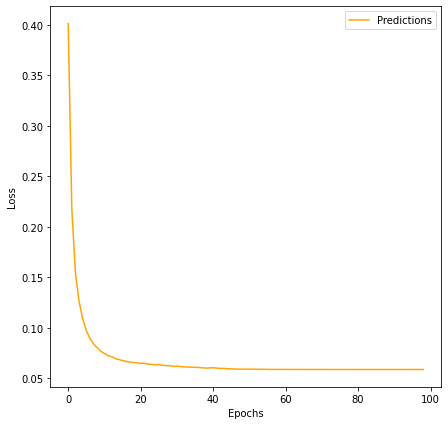

In [13]:
plt.figure(figsize=(7,7))
plt.plot(list(range(len(regrMLP.loss_curve_))), regrMLP.loss_curve_, color='orange', label='Predictions')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();
plt.show()

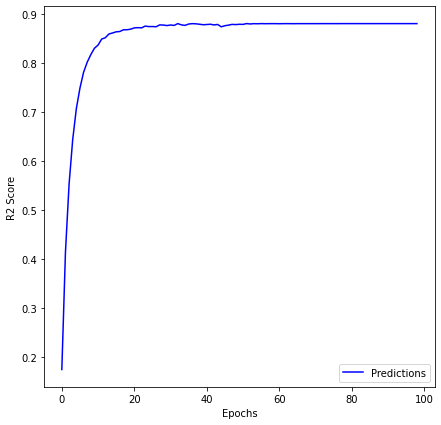

In [14]:

plt.figure(figsize=(7,7))
plt.plot(list(range(len(regrMLP.validation_scores_))), regrMLP.validation_scores_, color='blue', label='Predictions')
plt.xlabel("Epochs")
plt.ylabel("R2 Score")
plt.legend();
plt.show()



# Saving the model

In [19]:
save_model(regrMLP, name='mlp')

Saved in auto_mpg/models/10-Nov-2023-13-40-36-mlp.pickle


In [56]:
predicted = regrMLP.predict(testX)
test_mse_error = mean_squared_error(predicted, testY)
test_mae_error = mean_absolute_error(predicted, testY)
test_r2_error = r2_score(predicted, testY)

print(f'MSE error: {test_mse_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')

MSE error: 0.09588082106110349
MAE error: 0.22115992777567287
R2 error: 0.8611434453354265


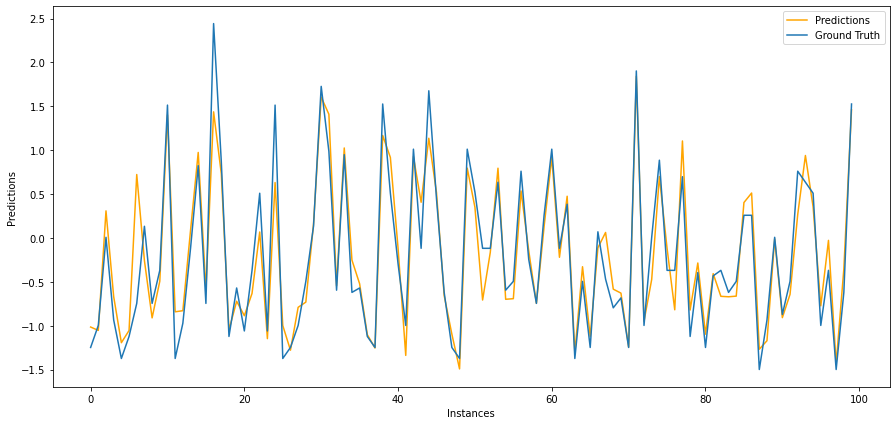

In [57]:
plt.figure(figsize=(15,7))
plt.plot(list(range(len(predicted))), predicted, color='orange', label='Predictions')
plt.plot(list(range(len(predicted))), testY.flatten(), label='Ground Truth')
plt.xlabel("Instances")
plt.ylabel("Predictions")
plt.legend()
plt.show()

# Grid Search CV for MLP

In [70]:
hidden_layer_sizes = [3, 5, 7, 9, 12]
activation = ['logistic', 'tanh', 'relu']
solver = ['sgd', 'adam']
batch_size = [8, 16]
learning_rate = ['adaptive', 'invscaling', 'constant']
max_iter = [100, 150, 200, 250]
early_stopping=[True]

parameters = dict(hidden_layer_sizes=hidden_layer_sizes, activation=activation, solver=solver,
                  batch_size=batch_size, learning_rate=learning_rate,
                  max_iter=max_iter, early_stopping=early_stopping)

In [72]:
parameters

{'hidden_layer_sizes': [3, 5, 7, 9, 12],
 'activation': ['logistic', 'tanh', 'relu'],
 'solver': ['sgd', 'adam'],
 'batch_size': [8, 16],
 'learning_rate': ['adaptive', 'invscaling', 'constant'],
 'max_iter': [100, 150, 200, 250],
 'early_stopping': [True]}

In [ ]:
regrMLP  = MLPRegressor()
regrMLP_GS = GridSearchCV(regrMLP, parameters)
regrMLP_GS.fit(trainX, trainY.ravel())


C:\Users\sudar\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\sudar\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\sudar\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\sudar\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\sudar\anaconda3\lib\site-packages\sklearn\neural_network\_multi

# Decision Tree
### Dry Run with static data split

In [32]:
# criterion='absolute_error', 'squared_error'
clf = tree.DecisionTreeRegressor(criterion='absolute_error', min_samples_leaf=2, min_samples_split=10, max_depth=50)
clf = clf.fit(trainX, trainY)
predicted = clf.predict(testX)
test_mse_error = mean_squared_error(predicted, testY)
test_mae_error = mean_absolute_error(predicted, testY)
test_r2_error = r2_score(predicted, testY)

print(f'MSE error: {test_mse_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')

MSE error: 0.1786818606748289
MAE error: 0.31544938767813563
R2 error: 0.7856911693198397


## Grid Search for Hyperparameters


In [53]:
# criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
criterion = ['squared_error', 'absolute_error']
max_depth = [10, 20, 30, 45, 50, 55, 60]
min_samples_split  = [5, 6, 7, 8, 9, 10, 11, 12, 13]
min_samples_leaf = [2, 3, 4, 5,6,7,8,9,]
max_features = [3, 5, 6]

parameters = dict(criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split,
                  min_samples_leaf=min_samples_leaf, max_features=max_features)

In [54]:
clf = tree.DecisionTreeRegressor(random_state=4)
clf_GS = GridSearchCV(clf, parameters)
clf_GS.fit(trainX, trainY)

print('Best Criterion:', clf_GS.best_estimator_.get_params()['criterion'])
print('Best max_depth:', clf_GS.best_estimator_.get_params()['max_depth'])
print('Best Number Of min_samples_leaf:', clf_GS.best_estimator_.get_params()['min_samples_leaf'])
print('Best Number Of min_samples_split:', clf_GS.best_estimator_.get_params()['min_samples_split'])

Best Criterion: squared_error
Best max_depth: 10
Best Number Of min_samples_leaf: 4
Best Number Of min_samples_split: 11


In [55]:
clf_GS.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 10,
 'max_features': 6,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 4,
 'min_samples_split': 11,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 4,
 'splitter': 'best'}

# Training the Decision Tree with the best parameters found using Grid Search

In [58]:
clf = tree.DecisionTreeRegressor(**clf_GS.best_estimator_.get_params())

clf = clf.fit(trainX, trainY)
predicted = clf.predict(testX)
test_mse_error = mean_squared_error(predicted, testY)
test_mae_error = mean_absolute_error(predicted, testY)
test_r2_error = r2_score(predicted, testY)


print(f'MSE error: {test_mse_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')


MSE error: 0.12448938545270176
MAE error: 0.24710450003279824
R2 error: 0.8264226498136288


In [61]:
save_model(clf, name='decisiontree')

Saved in auto_mpg/models/10-Nov-2023-14-07-49-decisiontree.pickle


## Line plot comparing the Ground Truth and Predicted values

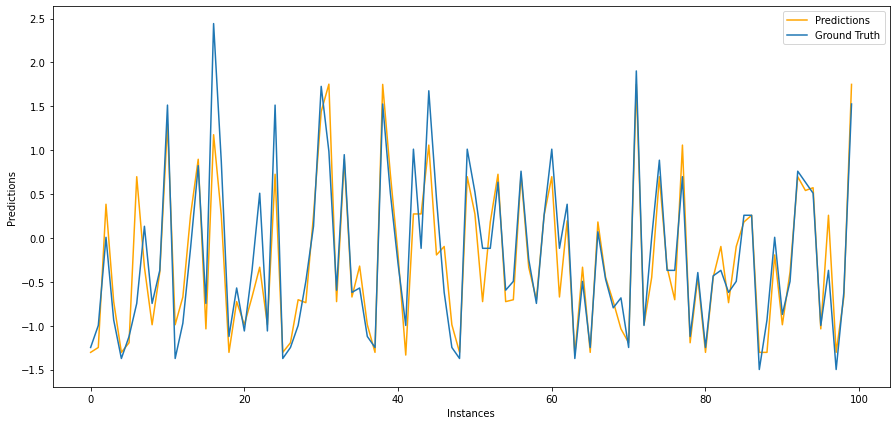

In [60]:
plt.figure(figsize=(15,7))
plt.plot(list(range(len(predicted))), predicted, color='orange', label='Predictions')
plt.plot(list(range(len(predicted))), testY.flatten(), label='Ground Truth')
plt.xlabel("Instances")
plt.ylabel("Predictions")
plt.legend()
plt.show()

# SVM

In [64]:
regr = svm.SVR()
regr.fit(trainX, trainY.ravel())

SVR()

### Dry Run

In [65]:
predicted = regr.predict(testX)
test_mse_error = mean_squared_error(predicted, testY)
test_mae_error = mean_absolute_error(predicted, testY)
test_r2_error = r2_score(predicted, testY)

print(f'MSE error: {test_mse_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')


MSE error: 0.0723055800190337
MAE error: 0.2020300008353153
R2 error: 0.8972139444127274


## Grid Search for Hyperparameters

In [66]:
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
degree = [2, 3, 4]
gamma  = ['scale', 'auto']

parameters = dict(kernel=kernel, degree=degree, gamma=gamma)

In [67]:
trainX.shape, trainY.ravel().shape

((298, 7), (298,))

In [68]:
regr = svm.SVR()
regr_GS = GridSearchCV(regr, parameters)
regr_GS.fit(trainX, trainY.ravel())

print('Best kernel:', regr_GS.best_estimator_.get_params()['kernel'])
print('Best degree:', regr_GS.best_estimator_.get_params()['degree'])
print('Best gamma:', regr_GS.best_estimator_.get_params()['gamma'])


Best kernel: rbf
Best degree: 2
Best gamma: auto


In [69]:
regr = svm.SVR(**regr_GS.best_estimator_.get_params())
regr.fit(trainX, trainY.ravel())

predicted = regr.predict(testX)
test_mse_error = mean_squared_error(predicted, testY)
test_mae_error = mean_absolute_error(predicted, testY)
test_r2_error = r2_score(predicted, testY)

print(f'MSE error: {test_mse_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')

MSE error: 0.0723055800190337
MAE error: 0.2020300008353153
R2 error: 0.8972139444127274


In [70]:
save_model(regr, name='svm')

Saved in auto_mpg/models/10-Nov-2023-14-12-07-svm.pickle


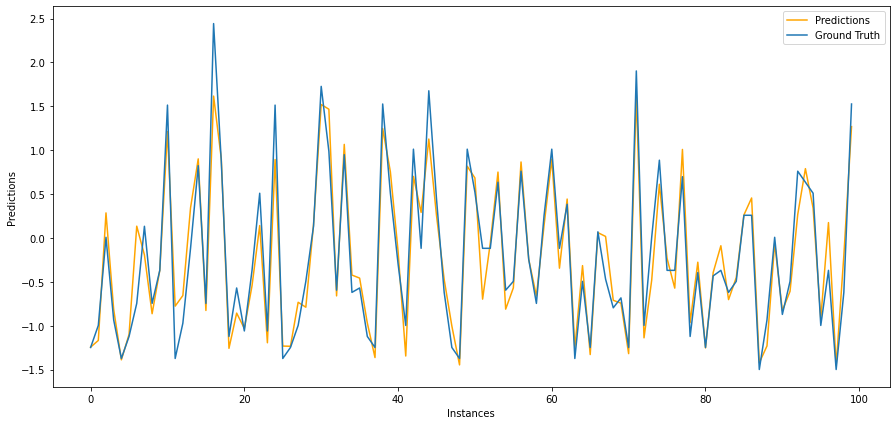

In [71]:
plt.figure(figsize=(15,7))
plt.plot(list(range(len(predicted))), predicted, color='orange', label='Predictions')
plt.plot(list(range(len(predicted))), testY.flatten(), label='Ground Truth')
plt.xlabel("Instances")
plt.ylabel("Predictions")
plt.legend()
plt.show()

# Linear Regreesion

In [81]:
model_sl = linear_model.LinearRegression(fit_intercept=True)
# x_train = data['weight'].values.reshape(-1, 1)
# y_train = data['mpg']
model_sl.fit(trainX[:,3].reshape(-1, 1), trainY)
model_sl.intercept_, model_sl.coef_

(array([2.06209587e-16]), array([[-0.83435319]]))

In [82]:
predicted = model_sl.predict(testX[:,3].reshape(-1, 1))
test_mse_error = mean_squared_error(predicted, testY)
test_mae_error = mean_absolute_error(predicted, testY)
test_r2_error = r2_score(predicted, testY)

print(f'MSE error: {test_mse_error}')
print(f'MAE error: {test_mae_error}')
print(f'R2 error: {test_r2_error}')

MSE error: 0.27680846971367795
MAE error: 0.4047634563455837
R2 error: 0.6049136463640524


In [84]:
save_model(model_sl, name='linear_regression')

Saved in auto_mpg/models/10-Nov-2023-14-29-06-linear_regression.pickle


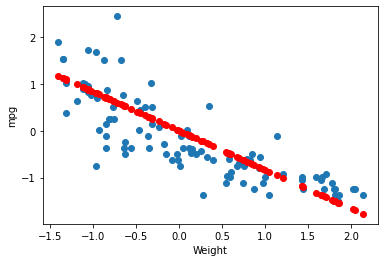

In [88]:
plt.scatter(testX[:,3],testY, label="actual")
plt.scatter(testX[:,3],predicted, color='red', label="predicted")
plt.xlabel("Weight")
plt.ylabel("mpg")
plt.show()